In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genextreme, genpareto, kstest, probplot
from statsmodels.tsa.stattools import acf
from scipy.stats import probplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genextreme, kstest, probplot
from statsmodels.tsa.stattools import acf
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('secu_1_M.csv', delimiter=';')

In [3]:
data['SOI_ANN'].value_counts()

SOI_ANN
2023    506843
2024    470315
2022     20125
2021      2085
0          386
2020       163
2019        59
2018        16
2017         6
2015         1
2016         1
Name: count, dtype: int64

In [4]:
data

,FLX_ANN_MOI,ORG_CLE_REG,AGE_BEN_SNDS,BEN_RES_REG,BEN_CMU_TOP,BEN_QLT_COD,BEN_SEX_COD,DDP_SPE_COD,ETE_CAT_SNDS,ETE_REG_COD,ETE_TYP_SNDS,ETP_REG_COD,ETP_CAT_SNDS,MDT_TYP_COD,MFT_COD,PRS_FJH_TYP,PRS_ACT_COG,PRS_ACT_NBR,PRS_ACT_QTE,PRS_DEP_MNT,PRS_PAI_MNT,PRS_REM_BSE,PRS_REM_MNT,FLT_ACT_COG,FLT_ACT_NBR,FLT_ACT_QTE,FLT_PAI_MNT,FLT_DEP_MNT,FLT_REM_MNT,SOI_ANN,SOI_MOI,ASU_NAT,ATT_NAT,CPL_COD,CPT_ENV_TYP,DRG_AFF_NAT,ETE_IND_TAA,EXO_MTF,MTM_NAT,PRS_NAT,PRS_PPU_SEC,PRS_REM_TAU,PRS_REM_TYP,PRS_PDS_QCP,EXE_INS_REG,PSE_ACT_SNDS,PSE_ACT_CAT,PSE_SPE_SNDS,PSE_STJ_SNDS,PRE_INS_REG,PSP_ACT_SNDS,PSP_ACT_CAT,PSP_SPE_SNDS,ETB_DCS_MCO,Unnamed: 54
0,202401,76,50,76,1,1,2,121,9999,99,99,99,9999,9,99,0,410.4,47.0,47,0.0,882.59,882.59,529.65,410.4,47.0,47,882.59,0.0,529.65,2023,10,10,0,0,1,36,9,0,0,3125,2,60.0,0,31,76,26,7,0,1,76,0,1,14,Z,NaN
1,202401,84,60,84,0,1,2,121,9999,99,99,99,9999,9,99,0,2.0,2.0,2,0.0,179.00,28.86,17.32,2.0,2.0,2,179.00,0.0,17.32,2023,11,10,0,0,1,11,9,0,0,3522,2,60.0,0,31,27,60,2,0,1,84,0,1,1,Z,NaN
2,202401,5,30,5,0,1,2,121,9999,99,99,32,1102,9,99,0,4.0,2.0,4,0.0,0.00,0.00,-2.00,4.0,2.0,4,0.00,0.0,-2.00,2024,1,10,0,0,1,11,9,62,0,1972,2,100.0,0,31,5,50,2,0,1,99,0,0,7,Z,NaN
3,202401,75,60,75,0,1,1,121,9999,99,99,99,9999,9,99,0,3.0,3.0,3,0.0,0.00,0.00,-1.50,3.0,3.0,3,0.00,0.0,-1.50,2023,12,10,0,0,1,11,9,41,0,1976,2,100.0,0,31,76,24,3,0,1,76,0,1,1,Z,NaN
4,202401,44,20,44,0,1,2,121,9999,99,99,99,9999,9,99,0,16.0,16.0,16,0.0,80.05,0.00,20.01,0.0,0.0,0,0.00,0.0,0.00,2023,12,10,0,0,8,35,9,62,2,3313,2,25.0,4,31,84,50,2,0,1,44,0,1,1,Z,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,202401,32,20,32,0,1,2,121,9999,99,99,99,9999,9,99,0,6.0,5.0,6,0.0,0.00,0.00,-2.77,6.0,5.0,6,0.00,0.0,-2.77,2024,1,10,0,0,1,11,9,62,0,1972,2,100.0,0,31,84,50,2,0,1,32,0,1,5,Z,NaN
999996,202401,44,0,44,0,3,2,121,9999,99,99,99,9999,9,99,8,21.0,NaN,21,0.0,10.71,10.71,6.93,21.0,NaN,21,10.71,0.0,6.93,2024,1,10,0,0,1,35,9,0,2,3364,2,65.0,0,31,44,50,2,0,9,44,19,4,0,Z,NaN
999997,202401,44,60,44,0,1,2,0,1102,44,1,44,1102,9,3,0,2.0,2.0,2,0.0,4.00,4.00,4.00,2.0,2.0,2,4.00,0.0,4.00,2023,10,10,0,0,2,35,1,20,0,1116,1,100.0,0,3,99,0,0,11,2,99,0,0,1,C,NaN
999998,202401,93,20,93,0,1,2,121,9999,99,99,99,9999,9,99,0,3.0,3.0,3,0.0,7.63,7.63,4.96,3.0,3.0,3,7.63,0.0,4.96,2024,1,10,0,0,1,35,9,0,0,3313,2,65.0,0,31,93,50,2,0,1,76,0,1,2,Z,NaN


In [5]:
data = data[['FLT_PAI_MNT', 'SOI_MOI', 'SOI_ANN']]

In [6]:
data = data[data['FLT_PAI_MNT'] > 0]

In [7]:
data['SOI_ANN'].value_counts()

SOI_ANN
2023    358562
2024    352002
2022     11894
2021      1066
2020        73
2019        35
2018         3
2017         2
2016         1
Name: count, dtype: int64

In [8]:
#data['FLT_PAI_MNT'] = np.log(data['FLT_PAI_MNT'])

In [9]:
data['FLT_PAI_MNT'].describe()

count    7.236380e+05
mean     4.621264e+02
std      9.436831e+03
min      1.000000e-02
25%      4.730000e+00
50%      2.500000e+01
75%      9.678000e+01
max      3.990468e+06
Name: FLT_PAI_MNT, dtype: float64

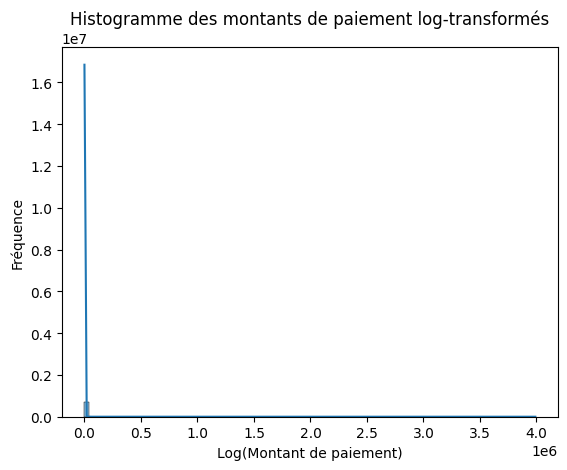

In [10]:
sns.histplot(data['FLT_PAI_MNT'], bins=100, kde=True)
plt.title('Histogramme des montants de paiement log-transformés')
plt.xlabel('Log(Montant de paiement)')
plt.ylabel('Fréquence')
plt.show()

## Distribution des maximums

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genextreme, kstest, probplot
from statsmodels.tsa.stattools import acf

# 1. Nettoyage et création de la date
data['SOI_ANN'] = pd.to_numeric(data['SOI_ANN'], errors='coerce')
data['SOI_MOI'] = pd.to_numeric(data['SOI_MOI'], errors='coerce')
data = data.dropna(subset=['SOI_ANN', 'SOI_MOI'])

data['SOI_ANN'] = data['SOI_ANN'].astype(int)
data['SOI_MOI'] = data['SOI_MOI'].astype(int)

data['SOI_DATE'] = pd.to_datetime({
    'year': data['SOI_ANN'],
    'month': data['SOI_MOI'],
    'day': 1
}, errors='coerce')

data = data.dropna(subset=['SOI_DATE'])

# 2. Création des blocs trimestriels
data['TRIMESTRE'] = data['SOI_DATE'].dt.to_period("Q")
quarterly_max = data.groupby('TRIMESTRE')['FLT_PAI_MNT'].max()
quarterly_max.index = quarterly_max.index.to_timestamp()

# 3. Estimation des paramètres GEV
gev_params = genextreme.fit(quarterly_max)
c, loc, scale = gev_params

# 4. ACF
acf_values = acf(quarterly_max, fft=False)

# 5. Bootstrap pour intervalle de confiance
n_bootstrap = 500
bootstrap_params = np.array([
    genextreme.fit(quarterly_max.sample(frac=1, replace=True))
    for _ in range(n_bootstrap)
])
param_means = bootstrap_params.mean(axis=0)
param_ci = np.percentile(bootstrap_params, [2.5, 97.5], axis=0)


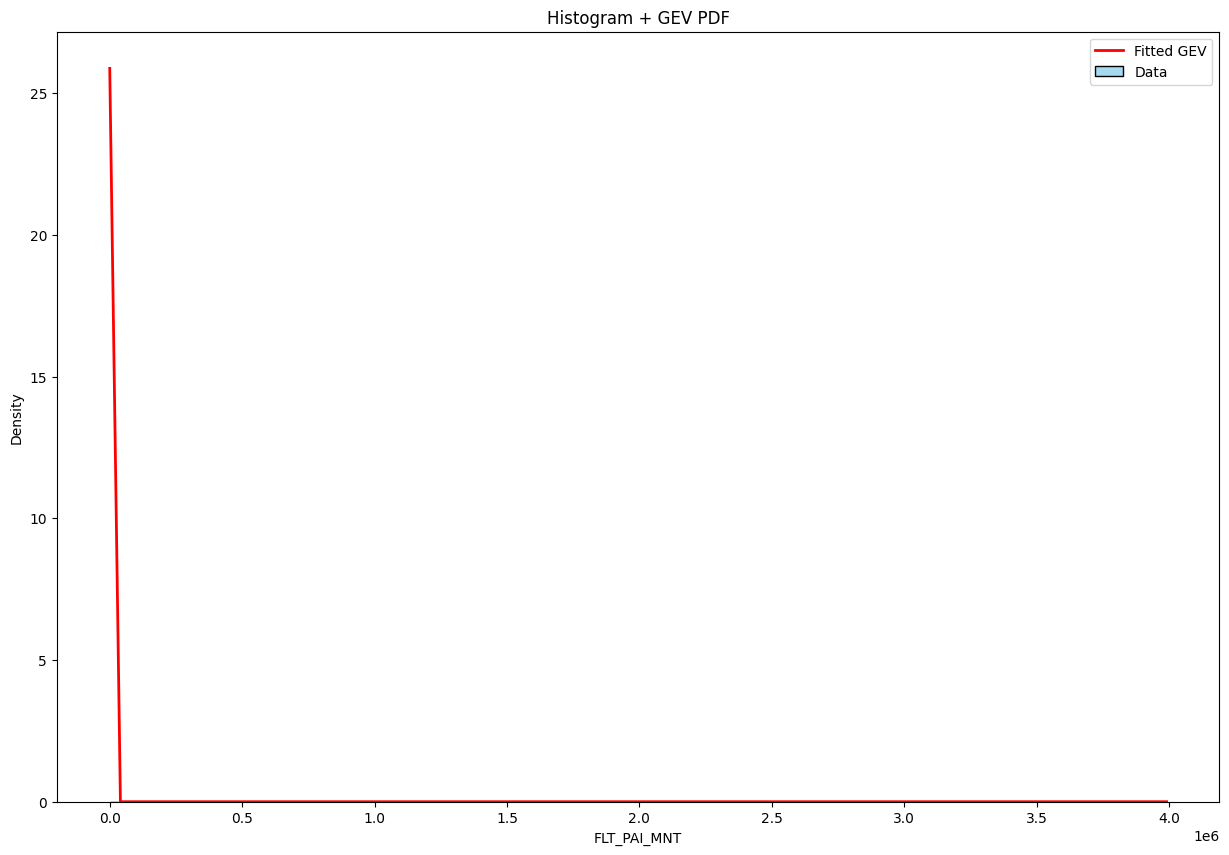

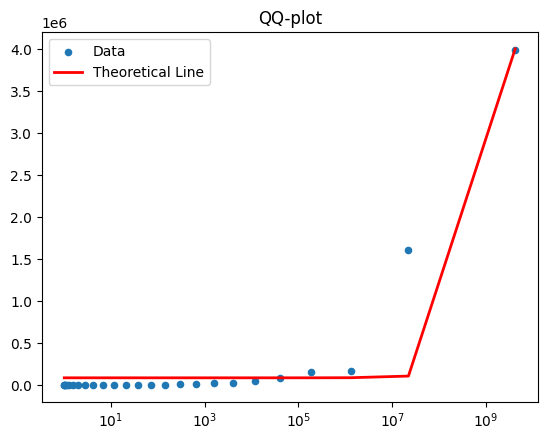

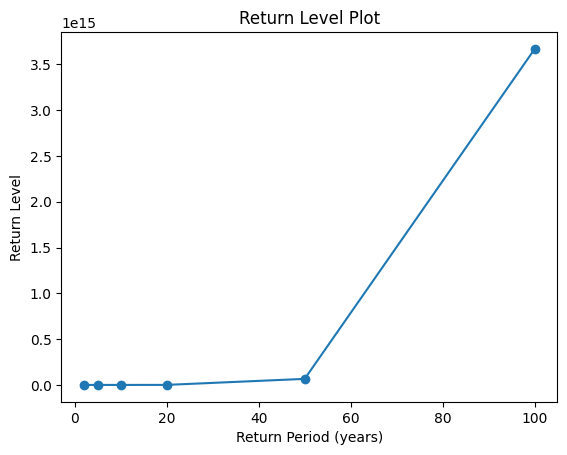

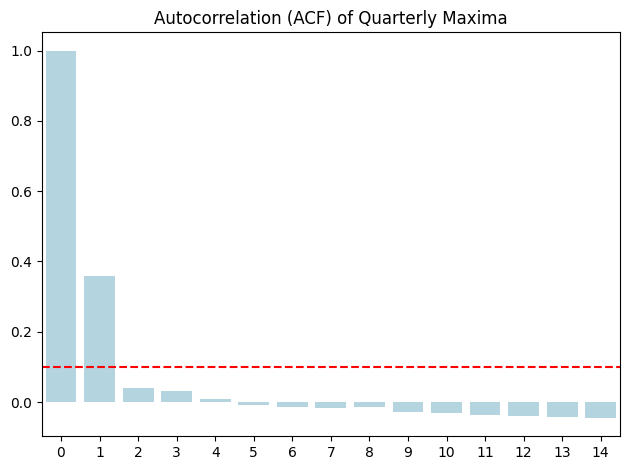

=== Summary of GEV Distribution Parameters ===
Shape (xi): -1.0138
Location (mu): 0.00
Scale (sigma): 1153.97

=== 95% Confidence Intervals (Bootstrap) ===
Shape: [-0.9924, -1.0334]
Location: [0.02, 0.06]
Scale: [1125.43, 1175.97]

=== Kolmogorov–Smirnov Test ===
KS statistic: 0.3870, p-value: 0.0005
→ The GEV may not be a good fit (p < 0.05)


In [ ]:
# 6. Plots
plt.figure(figsize=(15, 10))

# Histogram + GEV PDF
sns.histplot(quarterly_max, kde=False, stat="density", bins=20, color="skyblue", label="Data")
x = np.linspace(quarterly_max.min(), quarterly_max.max(), 100)
plt.plot(x, genextreme.pdf(x, *gev_params), 'r-', lw=2, label='Fitted GEV')
plt.title("Histogram + GEV PDF")
plt.legend()
plt.show()

# Enhanced QQ-plot
(pp_x, pp_y), (slope, intercept, r) = probplot(quarterly_max, dist=genextreme(*gev_params), plot=None)
plt.scatter(pp_x, pp_y, s=20, label="Data")
plt.plot(pp_x, slope * pp_x + intercept, 'r-', lw=2, label="Theoretical Line")
plt.title("QQ-plot")
plt.legend()
plt.show()

# Return Level Plot (quarters converted to years)
return_periods_years = np.array([2, 5, 10, 20, 50, 100])
return_periods_quarters = return_periods_years * 4  # 4 quarters per year
return_levels = genextreme.ppf(1 - 1 / return_periods_quarters, *gev_params)
plt.plot(return_periods_years, return_levels, marker='o')
plt.xlabel("Return Period (years)")
plt.ylabel("Return Level")
plt.title("Return Level Plot")
plt.show()

# ACF
sns.barplot(x=list(range(len(acf_values))), y=acf_values, color="lightblue")
plt.axhline(0.1, color='red', linestyle='--')
plt.title("Autocorrelation (ACF) of Quarterly Maxima")

plt.tight_layout()
plt.show()

# 7. Kolmogorov–Smirnov Test
ks_stat, ks_p = kstest(quarterly_max, lambda x: genextreme.cdf(x, *gev_params))

# 8. Summary
print("=== Summary of GEV Distribution Parameters ===")
print(f"Shape (xi): {-c:.4f}")
print(f"Location (mu): {loc:.2f}")
print(f"Scale (sigma): {scale:.2f}")
print("\n=== 95% Confidence Intervals (Bootstrap) ===")
print(f"Shape: [{-param_ci[0][0]:.4f}, {-param_ci[1][0]:.4f}]")
print(f"Location: [{param_ci[0][1]:.2f}, {param_ci[1][1]:.2f}]")
print(f"Scale: [{param_ci[0][2]:.2f}, {param_ci[1][2]:.2f}]")
print("\n=== Kolmogorov–Smirnov Test ===")
print(f"KS statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")
if ks_p > 0.05:
    print("→ The GEV is an acceptable distribution for these data (p > 0.05)")
else:
    print("→ The GEV may not be a good fit (p < 0.05)")


In [13]:
print(list(range(len(acf_values))), acf_values)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] [ 1.          0.35951406  0.03888778  0.0312409   0.00739748 -0.00892015
 -0.01486876 -0.01624498 -0.01452907 -0.02760196 -0.03200812 -0.03553584
 -0.03862918 -0.04159594 -0.04524605]


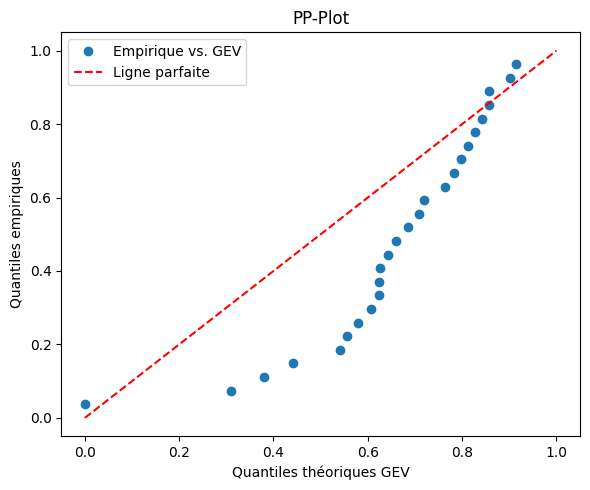


=== Test de sensibilité : paramètres GEV selon la taille du bloc ===


C:\Users\chris\AppData\Local\Temp\ipykernel_58796\3453420762.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  block_max = data.resample(freq, on='SOI_DATE')['FLT_PAI_MNT'].max().dropna()


Mensuel: Forme=5.1835, Position=3.70, Échelle=16.54


C:\Users\chris\AppData\Local\Temp\ipykernel_58796\3453420762.py:28: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  block_max = data.resample(freq, on='SOI_DATE')['FLT_PAI_MNT'].max().dropna()


Trimestriel: Forme=5.7850, Position=4.29, Échelle=18.93
Semestriel: Forme=6.3824, Position=59.00, Échelle=21.30


C:\Users\chris\AppData\Local\Temp\ipykernel_58796\3453420762.py:28: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  block_max = data.resample(freq, on='SOI_DATE')['FLT_PAI_MNT'].max().dropna()


Annuel: Forme=6.2549, Position=110.83, Échelle=20.82


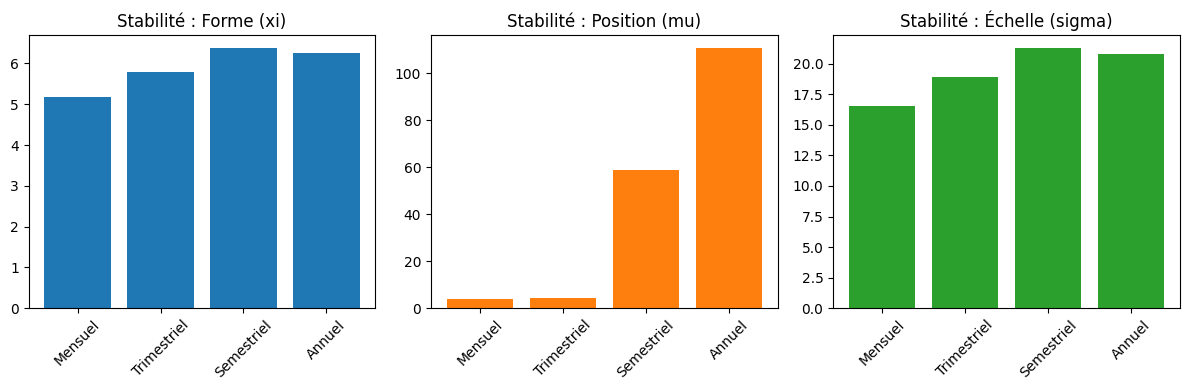

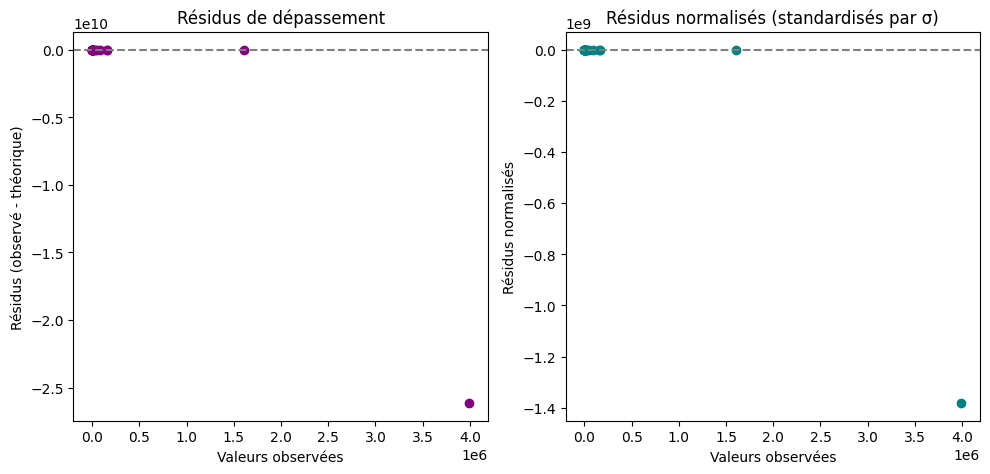

In [14]:
# === PP-PLOT ===
plt.figure(figsize=(6, 5))
empirical_cdf = np.arange(1, len(quarterly_max)+1) / (len(quarterly_max)+1)
sorted_data = np.sort(quarterly_max)
theoretical_cdf = genextreme.cdf(sorted_data, *gev_params)
plt.plot(theoretical_cdf, empirical_cdf, 'o', label="Empirique vs. GEV")
plt.plot([0, 1], [0, 1], 'r--', label="Ligne parfaite")
plt.xlabel("Quantiles théoriques GEV")
plt.ylabel("Quantiles empiriques")
plt.title("PP-Plot")
plt.legend()
plt.tight_layout()
plt.show()

# === TRACÉ DE STABILITÉ DES PARAMÈTRES GEV ===
print("\n=== Test de sensibilité : paramètres GEV selon la taille du bloc ===")
bloc_freqs = {
    'Mensuel': 'M',
    'Trimestriel': 'Q',
    'Semestriel': '2Q',
    'Annuel': 'A'
}

sensibility_results = {}

for label, freq in bloc_freqs.items():
    try:
        block_max = data.resample(freq, on='SOI_DATE')['FLT_PAI_MNT'].max().dropna()
        params = genextreme.fit(block_max)
        sensibility_results[label] = params
        print(f"{label}: Forme={-params[0]:.4f}, Position={params[1]:.2f}, Échelle={params[2]:.2f}")
    except Exception as e:
        print(f"{label}: erreur lors de l'ajustement ({e})")
        
plt.figure(figsize=(12, 4))
params_array = np.array([[label] + list(sensibility_results[label]) for label in sensibility_results])
param_labels = ['Forme (xi)', 'Position (mu)', 'Échelle (sigma)']
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i in range(3):
    plt.subplot(1, 3, i+1)
    values = [-float(row[i+1]) if i == 0 else float(row[i+1]) for row in params_array]
    plt.bar(list(sensibility_results.keys()), values, color=colors[i])
    plt.title(f"Stabilité : {param_labels[i]}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# === ANALYSE DES RÉSIDUS DE DÉPASSEMENT ===
# Résidus = différence entre les quantiles empiriques et les quantiles théoriques
sorted_data = np.sort(quarterly_max)
empirical_quantiles = (np.arange(1, len(sorted_data)+1) - 0.5) / len(sorted_data)
theoretical_quantiles = genextreme.ppf(empirical_quantiles, *gev_params)
residuals = sorted_data - theoretical_quantiles
normalized_residuals = residuals / scale  # Résidus standardisés par l’échelle

plt.figure(figsize=(10, 5))

# Résidus bruts
plt.subplot(1, 2, 1)
plt.plot(sorted_data, residuals, 'o', color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Résidus de dépassement")
plt.xlabel("Valeurs observées")
plt.ylabel("Résidus (observé - théorique)")

# Résidus normalisés
plt.subplot(1, 2, 2)
plt.plot(sorted_data, normalized_residuals, 'o', color='teal')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Résidus normalisés (standardisés par σ)")
plt.xlabel("Valeurs observées")
plt.ylabel("Résidus normalisés")

plt.tight_layout()
plt.show()


In [15]:
print('return_lvl' ,return_levels, 'return_periods' , return_periods_years)

return_lvl [3.74386696e+05 9.48664346e+07 5.63622999e+09 3.22400019e+11
 6.60637205e+13 3.66916774e+15] return_periods [  2   5  10  20  50 100]


## Distribution de Pareto Generalisé

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genpareto, kstest, probplot, anderson


# Récupération des données
values = data['FLT_PAI_MNT']

# 1. Choix du seuil u (ex: 95e percentile)
threshold = np.percentile(values, 95)
excesses = values[values > threshold] - threshold  # X - u

# 2. Ajustement de la loi GPD
gpd_params = genpareto.fit(excesses)
c, loc, scale = gpd_params

# 3. Bootstrap pour intervalle de confiance
n_bootstrap = 50  # Peut être augmenté
bootstrap_params = np.array([
    genpareto.fit(excesses.sample(frac=1, replace=True))
    for _ in range(n_bootstrap)
])
param_ci = np.percentile(bootstrap_params, [2.5, 97.5], axis=0)


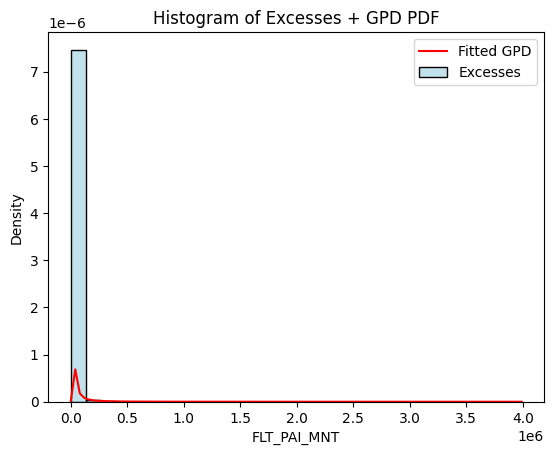

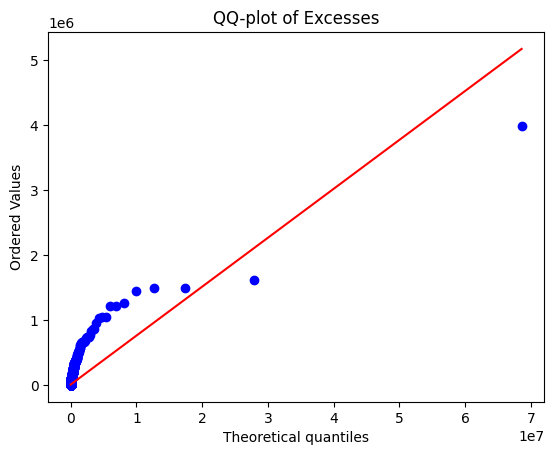

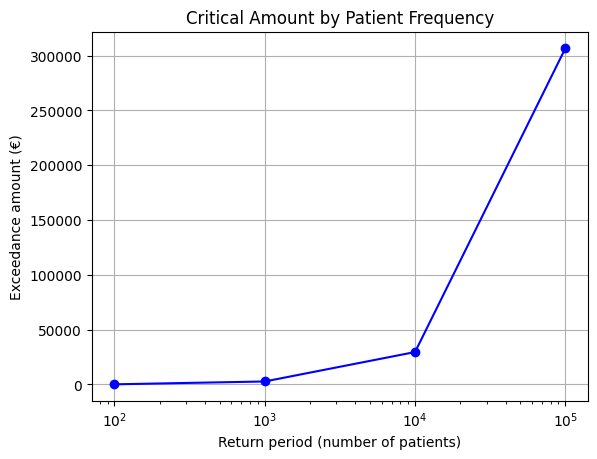

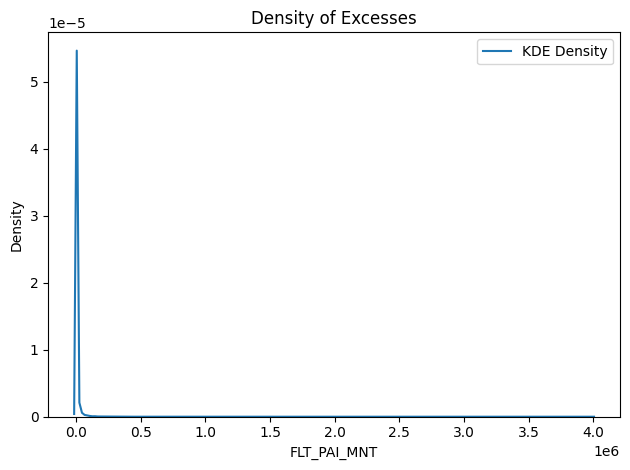

In [17]:
# 4. Plots

# Histogram + PDF
sns.histplot(excesses, bins=30, stat='density', color='lightblue', label='Excesses')
x = np.linspace(0, excesses.max(), 100)
plt.plot(x, genpareto.pdf(x, *gpd_params), 'r-', label='Fitted GPD')
plt.title("Histogram of Excesses + GPD PDF")
plt.legend()
plt.show()

# QQ-plot
probplot(excesses, dist=genpareto(*gpd_params), plot=plt)
plt.title("QQ-plot of Excesses")
plt.show()

# Return level plot with confidence interval
# Parameters
n_total_patients = len(values)  # 1 million
threshold = np.percentile(values, 95)
excesses = values[values > threshold] - threshold
n_excess = len(excesses)

# GPD Fit
c, loc, scale = genpareto.fit(excesses, floc=0)  # Force loc=0

# Return periods (in number of patients)
T_patients = np.array([100, 1000, 10000, 100000])  # e.g., from 100 to 100k patients
p = 1 / (T_patients * (n_excess / n_total_patients))  # Adjusted probability

# Return levels
return_levels = threshold + (scale / c) * ((p * n_total_patients / n_excess) ** (-c) - 1)

# Plot
plt.plot(T_patients, return_levels, 'bo-')
plt.xlabel("Return period (number of patients)")
plt.ylabel("Exceedance amount (€)")
plt.xscale('log')
plt.title("Critical Amount by Patient Frequency")
plt.grid(True)
plt.show()

# Density of excesses
sns.kdeplot(excesses, label="KDE Density")
plt.title("Density of Excesses")
plt.legend()

plt.tight_layout()
plt.show()

# 5. Kolmogorov-Smirnov Test
ks_stat, ks_p = kstest(excesses, lambda x: genpareto.cdf(x, *gpd_params))

# 6. Anderson-Darling Test (via scipy `anderson`, default is exponential distribution, approximation)
ad_statistic = anderson(excesses, dist='expon')

# 7. Summary
summary = {
    "xi": c,
    "sigma": scale,
    "xi_ci": (param_ci[0][0], param_ci[1][0]),
    "sigma_ci": (param_ci[0][2], param_ci[1][2]),
    "ks_stat": ks_stat,
    "ks_p": ks_p,
    "ad_stat": ad_statistic.statistic,
    "ad_critical": ad_statistic.critical_values,
    "ad_significance": ad_statistic.significance_level
}

In [192]:
print(T_patients, return_levels)

[   100   1000  10000 100000] [11.75029906 13.67094045 14.81444111 15.76020892 16.77160032 17.39137429]


In [193]:
styled_summary = f"""
=== Analyse des Excès (Méthode POT - Peaks Over Threshold) ===

Seuil utilisé : {threshold:.2f} (95e percentile)

=== Paramètres estimés de la loi Pareto Généralisée (GPD) ===
- Forme (xi) : {summary['xi']:.4f}
- Échelle (sigma) : {summary['sigma']:.2f}

=== Intervalles de confiance à 95 % (via bootstrap, {n_bootstrap} échantillons) ===
- xi ∈ [{summary['xi_ci'][0]:.4f}, {summary['xi_ci'][1]:.4f}]
- sigma ∈ [{summary['sigma_ci'][0]:.2f}, {summary['sigma_ci'][1]:.2f}]

=== Tests de validation de l'ajustement GPD ===

Kolmogorov-Smirnov :
- Statistique : {summary['ks_stat']:.4f}
- p-value : {summary['ks_p']:.4f}
- Conclusion : {"Ajustement acceptable (p > 0.05)" if summary['ks_p'] > 0.05 else "Ajustement discutable (p < 0.05)"}

Anderson-Darling (approximation par loi exponentielle) :
- Statistique : {summary['ad_stat']:.4f}
- Valeurs critiques (1%, 2.5%, 5%, 10%, 15%) : {summary['ad_critical']}
- Conclusion : {"Ajustement accepté au seuil de 5%" if summary['ad_stat'] < summary['ad_critical'][2] else "Rejet possible au seuil de 5%"}
"""

print(styled_summary)



=== Analyse des Excès (Méthode POT - Peaks Over Threshold) ===

Seuil utilisé : 6.24 (95e percentile)

=== Paramètres estimés de la loi Pareto Généralisée (GPD) ===
- Forme (xi) : -0.0647
- Échelle (sigma) : 1.14

=== Intervalles de confiance à 95 % (via bootstrap, 500 échantillons) ===
- xi ∈ [-0.0953, -0.0315]
- sigma ∈ [1.08, 1.19]

=== Tests de validation de l'ajustement GPD ===

Kolmogorov-Smirnov :
- Statistique : 0.0135
- p-value : 0.5047
- Conclusion : Ajustement acceptable (p > 0.05)

Anderson-Darling (approximation par loi exponentielle) :
- Statistique : 1.7549
- Valeurs critiques (1%, 2.5%, 5%, 10%, 15%) : [0.922 1.078 1.341 1.606 1.957]
- Conclusion : Rejet possible au seuil de 5%



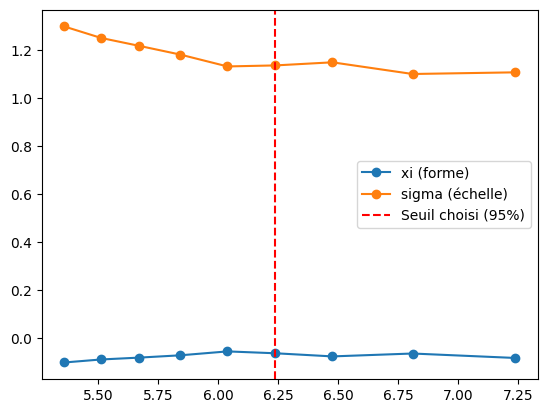

In [194]:
# 7. Stabilité des paramètres

thresholds = np.percentile(values, range(90, 99))
xi_estimates = []
sigma_estimates = []
for u in thresholds:
    excesses = values[values > u] - u
    c, _, scale = genpareto.fit(excesses, floc=0)  # Force loc=0
    xi_estimates.append(c)
    sigma_estimates.append(scale)

plt.plot(thresholds, xi_estimates, 'o-', label="xi (forme)")
plt.plot(thresholds, sigma_estimates, 'o-', label="sigma (échelle)")
plt.axvline(threshold, color='r', linestyle='--', label="Seuil choisi (95%)")
plt.legend()
plt.show()

In [196]:
print('thresholds', thresholds, 'xi_estimates', xi_estimates, 'sigma_estimates', sigma_estimates)

thresholds [5.35884786 5.51254126 5.66988092 5.8408579  6.0386496  6.23817422
 6.47568785 6.80970618 7.2371488 ] xi_estimates [-0.10309153602998988, -0.09054140325609694, -0.08283695657386245, -0.0732718010602123, -0.05687475407999745, -0.06467413353062719, -0.07774417191661631, -0.0656999215793153, -0.08424526642419752] sigma_estimates [1.2990543268134505, 1.2510636514364755, 1.2183812617334056, 1.1820983068110262, 1.1322923448581137, 1.1365588999165563, 1.1494963326005996, 1.1007631611161433, 1.1076800504299227]
